In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import os
import keras
from keras.models import Sequential
from sklearn.model_selection import train_test_split
# ,Model,load_model
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D
# from keras.callbacks import TensorBoard,ReduceLROnPlateau,ModelCheckpoint
# from sklearn import metrics
# import sklearn
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.preprocessing import MinMaxScaler

2023-09-24 22:18:58.706263: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-24 22:18:58.707905: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 22:18:58.743229: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-24 22:18:58.744055: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-24 22:18:59.269627: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
model_vgg16 = keras.applications.VGG16(weights='imagenet', input_shape=(224,224,3), include_top=False)
model_vgg16.trainable = False

2023-09-24 22:19:02.575783: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-24 22:19:02.576071: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [4]:
# !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2011/VOCtrainval_25-May-2011.tar -P data/

# !tar -xf data/VOCtrainval_25-May-2011.tar -C data/

--2023-09-24 21:33:27--  http://host.robots.ox.ac.uk/pascal/VOC/voc2011/VOCtrainval_25-May-2011.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1765686784 (1.6G) [application/x-tar]
Saving to: ‘data/VOCtrainval_25-May-2011.tar’

VOCtrainval_25-May- 100%[===================>]   1.64G  18.4MB/s    in 92s     

2023-09-24 21:35:01 (18.3 MB/s) - ‘data/VOCtrainval_25-May-2011.tar’ saved [1765686784/1765686784]



In [3]:
labels_path = r"../data/TrainVal/VOCdevkit/VOC2011/ImageSets/Main"
image_path = r"../data/TrainVal/VOCdevkit/VOC2011/JPEGImages"
file_list = os.listdir(labels_path)
for file in file_list:
    if "_train.txt" in file:
        df = pd.read_csv(f"{labels_path}/{file}", sep="\s+", names=["filename", "label"])
        true_count = df.loc[df.label==1].filename.count()
        print(f"{file}->{true_count}" )

sofa_train.txt->257
chair_train.txt->566
bird_train.txt->395
pottedplant_train.txt->269
bus_train.txt->213
car_train.txt->590
aeroplane_train.txt->327
cat_train.txt->539
sheep_train.txt->171
motorbike_train.txt->265
bicycle_train.txt->268
tvmonitor_train.txt->290
horse_train.txt->237
train_train.txt->273
diningtable_train.txt->269
boat_train.txt->260
person_train.txt->1994
bottle_train.txt->365
dog_train.txt->632
cow_train.txt->151


In [4]:
# Category Chosen Person as maximum number of inputs
category = "aeroplane"
train_label_path = os.path.join(labels_path, f"{category}_train.txt")
val_label_path = os.path.join(labels_path, f"{category}_val.txt")
train_label_df = pd.read_csv(train_label_path, sep="\s+", names=["filename", "label"])
test_label_df = pd.read_csv(val_label_path, sep="\s+", names=["filename", "label"])
train_label_df.loc[train_label_df["label"]!=1, 'label'] = 0
test_label_df.loc[test_label_df["label"]!=1, 'label'] = 0

# Sampling Data
true_sample_perc = 50
false_sample_perc = 10
df_true = train_label_df.loc[train_label_df["label"]==1].sample(frac=true_sample_perc/100, random_state=22)
df_false = train_label_df.loc[train_label_df["label"]==0].sample(frac=false_sample_perc/100, random_state=22)
# concat both true and false labels and shuffle them to get balanced data
final_train_labels = pd.concat([df_true, df_false], ignore_index=True).sample(frac=1).reset_index(drop=True)
test_label_df.groupby("label").count()
final_train_labels.groupby("label").count()

,filename
label,
0,539
1,164


In [5]:
def load(file_path):
    transform = keras.models.Sequential([
    keras.layers.experimental.preprocessing.Rescaling(1.0/255),
    keras.layers.experimental.preprocessing.Normalization()
])
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = transform(img)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (224, 224))
    return img

def data_preprocessing(df: pd.DataFrame):
    images = []
    labels = []
    for row in df.itertuples():
        filename = row.filename
        label = row.label
        image = load(os.path.join(image_path, f"{filename}.jpg"))
        images.append(image)
        labels.append(label)
    labels = np.array(labels).astype("float")
    images = np.array(images)
    return images, labels

X, y = data_preprocessing(final_train_labels)


Class in test data is: aeroplane Class A


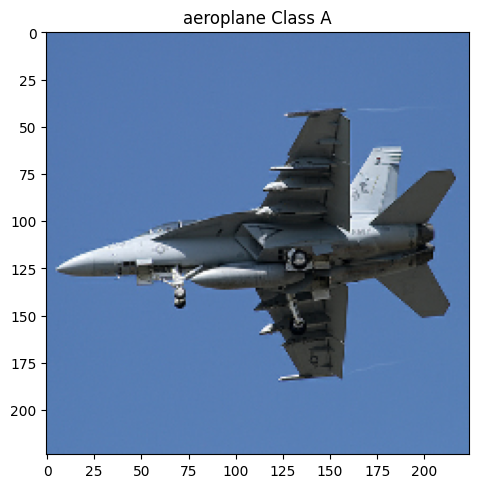

In [7]:
def printClass(cat):
      return f"{category} Class A" if cat == 1 else f"Not {category} Class Not A"
def random_check(X, y):
    image_number = random.randint(0, len(X))
    img = X[image_number]
    cat = y[image_number]
    plt.figure(figsize=(12, 12))
    plt.subplot(121)
    plt.title(printClass(cat))
    plt.imshow(img)
    print(f"Class in test data is: {printClass(cat)}")
    plt.show()

random_check(X,y)

In [35]:
# Split data for training and validation
X_train, X_val, y_train, y_val =  train_test_split(X,y,test_size = 0.2)
y_train = y_train.reshape((-1,1))
y_val = y_val.reshape((-1,1))
print(X_train.shape)
print(y_train.shape)

(562, 224, 224, 3)
(562, 1)


In [36]:
final_model = keras.models.Sequential()
final_model.add(model_vgg16)
# Add a flatten layer
final_model.add(Flatten())
final_model.add(Dense(1, activation="sigmoid"))

# Compile the model with categorical crossentropy loss and adam optimizer
final_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [37]:
model_fit = final_model.fit(X_train,y_train, epochs=10, batch_size=64, validation_data=(X_val,y_val))

Epoch 1/10
9/9 [==============================] - 22s 2s/step - loss: 0.4783 - accuracy: 0.8132 - val_loss: 0.3249 - val_accuracy: 0.8865
Epoch 2/10
9/9 [==============================] - 23s 3s/step - loss: 0.2000 - accuracy: 0.9128 - val_loss: 0.3218 - val_accuracy: 0.8440
Epoch 3/10
9/9 [==============================] - 23s 3s/step - loss: 0.1409 - accuracy: 0.9466 - val_loss: 0.2712 - val_accuracy: 0.9078
Epoch 4/10
9/9 [==============================] - 22s 2s/step - loss: 0.1022 - accuracy: 0.9591 - val_loss: 0.2190 - val_accuracy: 0.9007
Epoch 5/10
9/9 [==============================] - 23s 3s/step - loss: 0.0771 - accuracy: 0.9715 - val_loss: 0.1993 - val_accuracy: 0.9220
Epoch 6/10
9/9 [==============================] - 23s 3s/step - loss: 0.0559 - accuracy: 0.9911 - val_loss: 0.1853 - val_accuracy: 0.9078
Epoch 7/10
9/9 [==============================] - 23s 3s/step - loss: 0.0470 - accuracy: 0.9947 - val_loss: 0.1857 - val_accuracy: 0.9220
Epoch 8/10
9/9 [==================

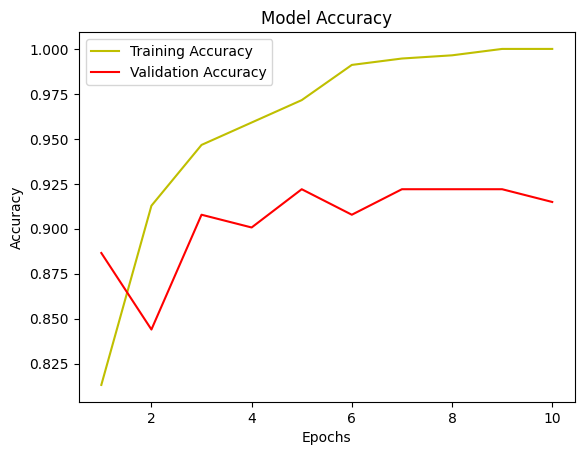

In [39]:
# plotting train and val accuracy in each epoch
accuracy = model_fit.history['accuracy']
val_accuracy = model_fit.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [40]:
X_test, y_test = data_preprocessing(test_label_df)
predicted_y = final_model.predict(X_test)

182/182 [==============================] - 186s 1s/step


1/1 [==============================] - 0s 52ms/step


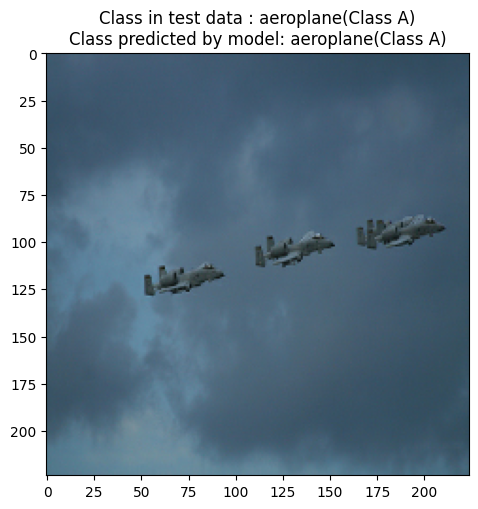

In [49]:
image_number = random.randint(0, len(X_test))
test_one = final_model.predict(np.array([X_test[image_number]]))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title(f"Class in test data : {printClass(y_test[image_number])}\n"+f"Class predicted by model: {printClass(np.round_(test_one[0]))}")
plt.imshow(X_test[image_number])
plt.show()

In [50]:
# Convert float values to binary
predicted_y = (np.round_(predicted_y)).reshape(-1)

# Import metrics functions
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate and print accuracy
accuracy = accuracy_score(y_test, predicted_y)
print(f"Accuracy: {accuracy}")

# Calculate and print precision
precision = precision_score(y_test, predicted_y)
print(f"Precision: {precision}")

# Calculate and print recall
recall = recall_score(y_test, predicted_y)
print(f"Recall: {recall}")

# Calculate and print f1-score
f1 = f1_score(y_test, predicted_y)
print(f"F1-score: {f1}")

Accuracy: 0.9510561566202989
Precision: 0.5606694560669456
Recall: 0.7813411078717201
F1-score: 0.6528623629719854


In [67]:
X_flattened = X.reshape(X.shape[0], -1)
X_validation_flattened = X_test.reshape(X_test.shape[0], -1)

# Normalize the features using Min-Max scaling
scaler = MinMaxScaler()
normalized_features = scaler.fit_transform(X_flattened)
normalized_val_features = scaler.transform(X_validation_flattened)


In [68]:

# Train and predict kNN classifiers with different hyperparameters
import itertools
k_values = [5, 7]
distance_metrics = ['euclidean', 'manhattan']

for k, distance_metric in itertools.product(k_values, distance_metrics):
    # Initialize kNN classifier
    knn_classifier = KNeighborsClassifier(n_neighbors=k, metric=distance_metric)

    # Train kNN classifier
    knn_classifier.fit(normalized_features, y)

    y_pred = knn_classifier.predict(normalized_val_features)

    accuracy_score_value = accuracy_score(y_test, y_pred)
    confusion_mat = metrics.confusion_matrix(y_test, y_pred)
    print(f"K Value -> {k}, Distance Metric -> {distance_metric}")
    print("Accuracy:", accuracy_score_value)
    print("Confusion Matrix:\n", confusion_mat)

K Value -> 5, Distance Metric -> euclidean
Accuracy: 0.5761634896101666
Confusion Matrix:
 [[3065 2415]
 [  53  290]]
K Value -> 5, Distance Metric -> manhattan
Accuracy: 0.6419371458011335
Confusion Matrix:
 [[3470 2010]
 [  75  268]]
K Value -> 7, Distance Metric -> euclidean
Accuracy: 0.6015799416108535
Confusion Matrix:
 [[3210 2270]
 [  50  293]]
K Value -> 7, Distance Metric -> manhattan
Accuracy: 0.6658080027477246
Confusion Matrix:
 [[3606 1874]
 [  72  271]]
